This file implements the `intent_2_stage` out-of-scope intent handling by adding the `stage 1` (ie. binary) classifier at the end of the pipeline. The pipeline ordering is not efficient but an easy way to test the performance of the oos handling. 

To run the evaluation (on UBS data)
1.  Split the positive UBS data into test and train sets. Negative examples are added to the training set during intent_2_stage training, but still need to be added to the testing set.
2.  Train an interpreter.
3.  Use make_test_set from intent_2_stage to append oos examples to the specified testing json file.
4.  Run the evaluate.py script.

*Note: make sure to check the source code of intent_2_stage to update if twitter/facebook files are being scraped

In [1]:
## The cell ensures that scripts are reimported if source code is changed
%load_ext autoreload
%autoreload 2

In [2]:
## Import required packages
from __future__ import unicode_literals
import logging, io, json
from rasa_nlu.training_data import TrainingData
from rasa_nlu.model import Interpreter, Trainer
from rasa_nlu.config import RasaNLUConfig
from rasa_nlu.converters import load_data
from rasa_nlu.classifiers import sklearn_intent_classifier
from rasa_nlu.classifiers import intent_2_stage
from rasa_nlu.classifiers import intent_threshold
from rasa_nlu.featurizers import spacy_featurizer

def pprint(o):
    print(json.dumps(o, indent=2))
    
logging.basicConfig(level="INFO")

In [3]:
## Specify the processing pipeline
model_config = {
  "pipeline": ["nlp_spacy",
               "ner_spacy",
               "intent_featurizer_spacy",
               "intent_featurizer_ngrams",
               "intent_classifier_sklearn",
               "intent_2_stage"],
  "language": "en"
}

In [4]:
import rasa_nlu

rasa_nlu.__version__

u'0.10.0a0'

In [5]:
## Partition ubs.ger.json into partial (only positive class data) test and training sets - step 1.
import numpy as np

s = 0.85
in_path = '/home/sarenne/rasa_nlu/data/ubs.ger.json'
out_path = '/home/sarenne/rasa_nlu/data/ubs'

combined_intents_train = []
combined_intents_test = []
with open(in_path) as data_file:
    intent_dict = json.load(data_file)['rasa_nlu_data']['common_examples']
np.random.shuffle(intent_dict) # shuffle the utterences
combined_intents_train.extend(intent_dict[:int(len(intent_dict)*s)])
combined_intents_test.extend(intent_dict[int(len(intent_dict)*s):])

with open(out_path + '_train.json', "w") as outfile:
    json.dump({"rasa_nlu_data": {"common_examples":combined_intents_train}}, outfile, indent=2)
with open(out_path + '_test.json', "w") as outfile:
    json.dump({"rasa_nlu_data": {"common_examples":combined_intents_test}}, outfile, indent=2)


In [6]:
# Train NLU model - step 2.
config = RasaNLUConfig(cmdline_args=model_config)
config["negative_data_path"] = "/home/sarenne/twitter_dumper/Wissensbox_tweets.csv"

trainer = Trainer(config)
training_data = load_data("/home/sarenne/rasa_nlu/data/ubs_train.json")

# run the training
interpreter = trainer.train(training_data)
logging.info("done")

INFO:rasa_nlu.utils.spacy_utils:Trying to load spacy model with name 'en'
INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.converters:Training data format at /home/sarenne/rasa_nlu/data/ubs_train.json is rasa_nlu
INFO:rasa_nlu.training_data:Training data stats: 
	- intent examples: 1728 (12 distinct intents)
	- found intents: 'ask_about_libor', 'enter_number', 'faq', 'handoff', 'mood_affirm', 'mood_deny', 'mood_goodbye', 'mood_greet', 'request_financial_calculation', 'request_financial_rules', 'retrieve_interest', 'thankyou'
	- entity examples: 0 (0 distinct entities)
	- found entities: 

INFO:rasa_nlu.model:Starting to train component nlp_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_featurizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:S

Fitting 2 folds for each of 6 candidates, totalling 12 fits


/home/sarenne/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   21.9s finished
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_2_stage


Fitting 3 folds for each of 6 candidates, totalling 18 fits


INFO:rasa_nlu.model:Finished training component.
INFO:root:done


In [13]:
## Test the trained interpreter 
result = interpreter.parse(
  "ich")
pprint(result)

{
  "entities": [], 
  "intent": {
    "confidence": 0.23947452532553254, 
    "name": "faq"
  }, 
  "text": "ich", 
  "intent_ranking": [
    {
      "confidence": 0.23947452532553254, 
      "name": "faq"
    }, 
    {
      "confidence": 0.23644899086036755, 
      "name": "request_financial_calculation"
    }, 
    {
      "confidence": 0.14259304045387822, 
      "name": "request_financial_rules"
    }, 
    {
      "confidence": 0.06633427826502966, 
      "name": "mood_deny"
    }, 
    {
      "confidence": 0.0593926487221166, 
      "name": "retrieve_interest"
    }, 
    {
      "confidence": 0.055162306170420936, 
      "name": "handoff"
    }, 
    {
      "confidence": 0.05028493003956998, 
      "name": "ask_about_libor"
    }, 
    {
      "confidence": 0.04429019357333219, 
      "name": "mood_affirm"
    }, 
    {
      "confidence": 0.02858581733957056, 
      "name": "enter_number"
    }, 
    {
      "confidence": 0.0284693762493457, 
      "name": "mood_greet"
    

In [7]:
## Create the evalutation test set - step 3.
I2S = intent_2_stage.Intent2Stage()
I2S.make_test_set("/home/sarenne/rasa_nlu/data/ubs_test.json", config)

Intent Evaluation Results
F1-Score:  0.854422744705
Precision: 0.862402242566
Accuracy:  0.85737704918
Classification report: 
                               precision    recall  f1-score   support

                 enter_number       0.25      1.00      0.40         2
                          faq       0.81      0.93      0.87       269
                      handoff       0.50      0.40      0.44         5
                    mood_deny       0.00      0.00      0.00         2
                 mood_goodbye       0.00      0.00      0.00         1
                   mood_greet       0.00      0.00      0.00         0
                 out_of_scope       0.94      0.85      0.89       305
request_financial_calculation       0.67      0.29      0.40         7
            retrieve_interest       0.82      0.53      0.64        17
                     thankyou       0.00      0.00      0.00         2

                  avg / total       0.86      0.86      0.85       610



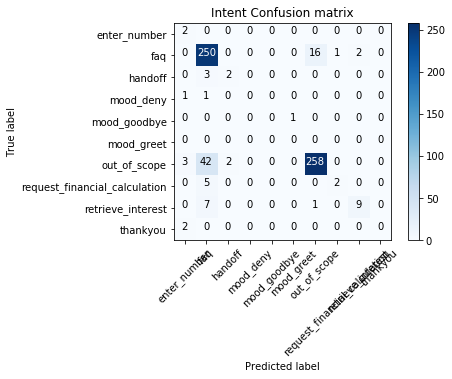

In [8]:
## Run evaluation - step 4.
from rasa_nlu.evaluate import run_intent_evaluation

config["data"] = "/home/sarenne/rasa_nlu/data/ubs_test.json"
run_intent_evaluation(config, interpreter)